In [1]:
import sys
sys.path.append("..")

In [2]:
import itertools
import random
import time

import numpy as np
import torch
import torchvision.datasets
from torch import nn

from utils import InMemDataLoader, Model, Model2D, Dropout, SGD, compute_error_rate, BatchNorm2d

In [3]:
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

In [4]:
batch_size = 128
data_path = "../data"

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))]
)

_test = torchvision.datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(data_path, train=True, download=True, transform=transform)
_train.data = _train.data[:50000]
_train.targets = _train.targets[:50000]

_valid = torchvision.datasets.MNIST(data_path, train=True, download=True, transform=transform)
_valid.data = _valid.data[50000:]
_valid.targets = _valid.targets[50000:]

mnist_loaders = {
    "train": InMemDataLoader(_train, batch_size=batch_size, shuffle=True),
    "valid": InMemDataLoader(_valid, batch_size=batch_size, shuffle=False),
    "test": InMemDataLoader(_test, batch_size=batch_size, shuffle=False),
}

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

----------------------------------------------------------
After epoch 26 | valid err rate:  2.09% | doing  38 epochs
----------------------------------------------------------
Minibatch  10200  | loss  1.46 | err rate  3.91%, steps/s 5813.24
Minibatch  10300  | loss  1.44 | err rate  1.56%, steps/s 6759.89

Loading best params on validation set (epoch 25)

--------------------------------------------
Test error rate: 2.120%, training took 163s.
--------------------------------------------


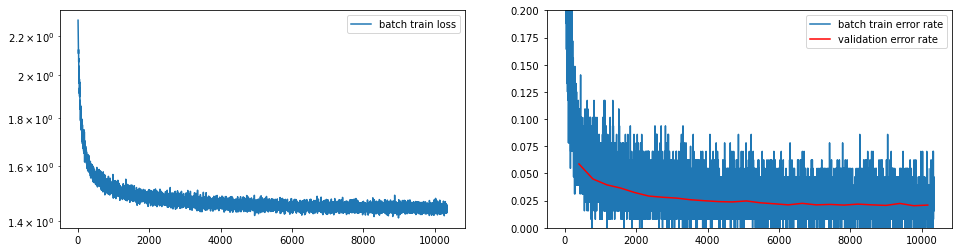

In [6]:
model = Model2D(
    Dropout(0.2),
    nn.Conv2d(1, 64, (3, 3)), nn.ReLU(inplace=True), nn.MaxPool2d((2, 2)), BatchNorm2d(64),
    nn.Conv2d(64, 128, (3, 3)), nn.ReLU(inplace=True), nn.MaxPool2d((2, 2)), BatchNorm2d(128),
    nn.Conv2d(128, 256, (3, 3)), nn.ReLU(inplace=True), nn.MaxPool2d((3, 3)), BatchNorm2d(256),
    Model(
        nn.Linear(256, 10),
    ),
)

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if "weight" in name:
            nn.init.xavier_normal_(p, gain=nn.init.calculate_gain("relu"))
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

def alpha():
    yield from itertools.repeat(1e-1, 15)
    yield from itertools.repeat(5e-2, 15)
    yield from itertools.repeat(2e-2)

# On GPU enabled devices set device='cuda' else set device='cpu'
t_start = time.time()
SGD(model, mnist_loaders, alpha=alpha(), epsilon=1e-2, norm_constraint=1, device="cuda", max_num_epochs=100)


test_err_rate = compute_error_rate(model, mnist_loaders["test"])
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))